In [1]:
library(randomForest)
library(tree)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



In [2]:
rmse = function(a,b){
    sqrt( mean((a - b)^2) )
}

In [3]:
citas = read.csv("data/ARIA_cleaned/citas.csv")

c_categ = c('ActivityCategoryCode', 'Status_pres', 'MultiFieldOptFlag', 'ObjectStatus_sec', 'TreatmentIntentType', 'StartDelay_isNaN', 'InterfaceStamp', 'ActualMachineSer', 'MorningAfternoon', 'PatientStatus', 'FractionFrequency', 'NoEditFlag_cat', 'SummaryStage', 'ObjectStatus_planes', 'MStage', 'Sex', 'ClinicalStatus', 'NotificationPriorTimeFlag_a', 'SkinFlashMargin', 'ActivityCode', 'NumberOfFractions_isNaN', 'PlanNormMethod', 'Status_rtpps', 'PrescribedDose_isNaN', 'Bolus', 'AssignableFlag', 'NotificationPriorTime_a', 'DiagnosisCode_sec', 'NotificationPriorTimeFlag_sch', 'TechniqueSer', 'Priority', 'DayOfWeek', 'ScheduledActivityCode', 'EquipmentSer', 'Intent', 'TStage', 'CityOrTownship', 'Description', 'SimulationNeeded', 'EnergyModeSer', 'DateOfBirth_isNaN', 'NoEditFlag_sch', 'AnchorActivityFlag', 'DicomSeqNumber', 'HistologyCode', 'PhaseType', 'Technique', 'TumorSize_isNaN', 'NotificationPriorTime_sch', 'NStage', 'Site', 'CalcModelOptions', 'PrimaryPTVSer_isNaN', 'TreatmentOrientation', 'Notes', 'DiagnosisCode', 'SchedulableFlag', 'ResourceGroupSer')

citas[c_categ] <- lapply(citas[c_categ], factor)

citas[c("Duration","DefaultDuration","ScheduledDuration",'ScheduledActivitySer','StartDateTime',"ScheduledStartTime",
        "ScheduledEndTime","ActualStartDate","ActualEndDate")] = NULL

dim(citas)

[1] 76881    72

In [4]:
y = citas$ActualDuration
x = citas[setdiff(names(citas), "ActualDuration")]

In [5]:
n <- nrow(citas)
r = 0.7
set.seed(1)
# i <- sample(1:n, round(r*n))
i = seq(1,round(r*n))
j <- setdiff(1:n, i)

x_tr = x[i,]
y_tr = y[i]

x_te = x[j,]
y_te = y[j]

dim(x_tr)

[1] 53817    71

In [6]:
# sapply(x_tr, class)

# Random Forest

### Parallel

In [8]:
library(doParallel)
library(parallel)

no_cores <- detectCores(logical = TRUE)
cl <- makeCluster(no_cores-1)
registerDoParallel(cl)

In [24]:
randomForest2 = function(ntree){
    rf = randomForest(x = x_tr, y = y_tr,
                      ntree = ntree,
                      mtry = 55,
                      
                      replace = FALSE,
                      sampsize = ceiling(nrow(x_tr)*0.2),
                      
                      maxnodes = 2000,  # max 3500
#                       nodesize = 50,
                      
#                       importance = TRUE,
#                       corr.bias = TRUE,
                    )
    return(rf)
}

clusterExport(cl, c('randomForest2','randomForest', 'x_tr', 'y_tr'))

In [25]:
rfs = parLapply(cl, rep(9,7), fun = randomForest2)

In [26]:
rf_comb = combine(rfs[[1]], rfs[[2]], rfs[[3]], rfs[[4]], rfs[[5]], rfs[[6]], rfs[[7]])

y_pred = predict(rf_comb, x_tr)
cat("rmse = ", rmse(y_tr, y_pred), "\n")
cat("cor pearson = ", cor(y_tr, y_pred, method = "pearson"), "\n")

y_pred = predict(rf_comb, x_te)
cat("rmse = ", rmse(y_te, y_pred), "\n")
cat("cor pearson = ", cor(y_te, y_pred, method = "pearson"), "\n")

rmse =  5.398888 
cor pearson =  0.8413026 
rmse =  6.743613 
cor pearson =  0.7640966 


### one randomForest

In [ ]:
model1 = randomForest(x = x_tr, y = y_tr,
                      ntree = 100,
                      mtry = 55,
                      
                      replace = FALSE,
                      sampsize = ceiling(nrow(x_tr)*0.2),
                      
                      maxnodes = 2000,  # max 3500
#                       nodesize = 50,
                      
#                       importance = TRUE,
                      corr.bias = TRUE,
                    )

In [ ]:
# str(model1) # max: 5579

rmse =  5.330668 
cor pearson =  0.8468028 


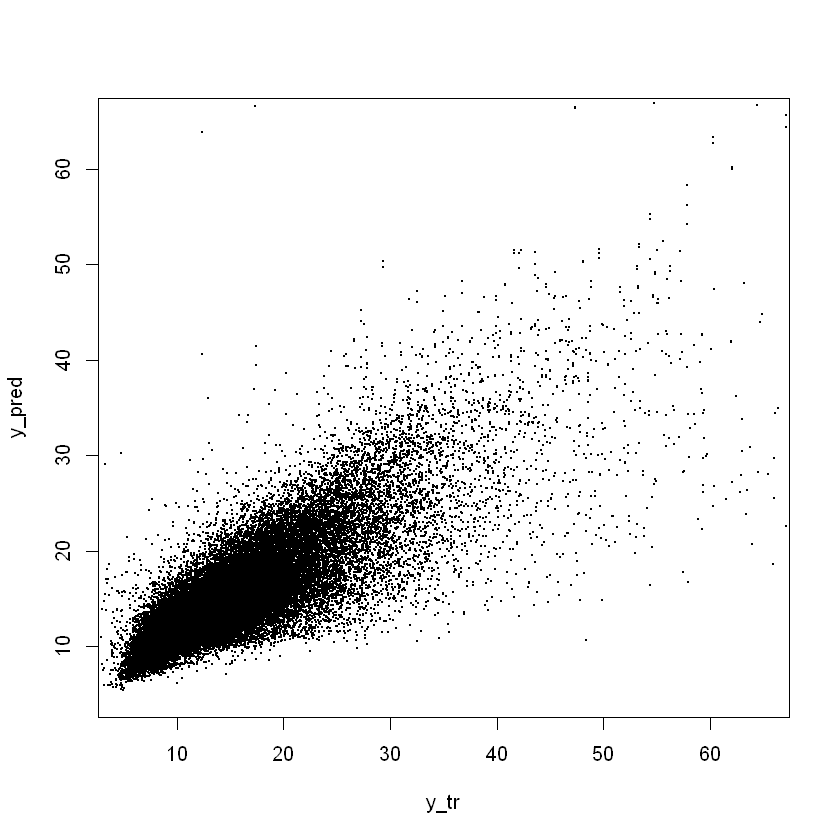

In [32]:
y_pred = predict(model1, x_tr)
cat("rmse = ", rmse(y_tr, y_pred), "\n")
cat("cor pearson = ", cor(y_tr, y_pred, method = "pearson"), "\n")
plot(y_tr, y_pred, xlim=c(5,65), ylim=c(5,65), pch=20, cex = 0.1)

rmse =  6.731603 
cor pearson =  0.7655374 


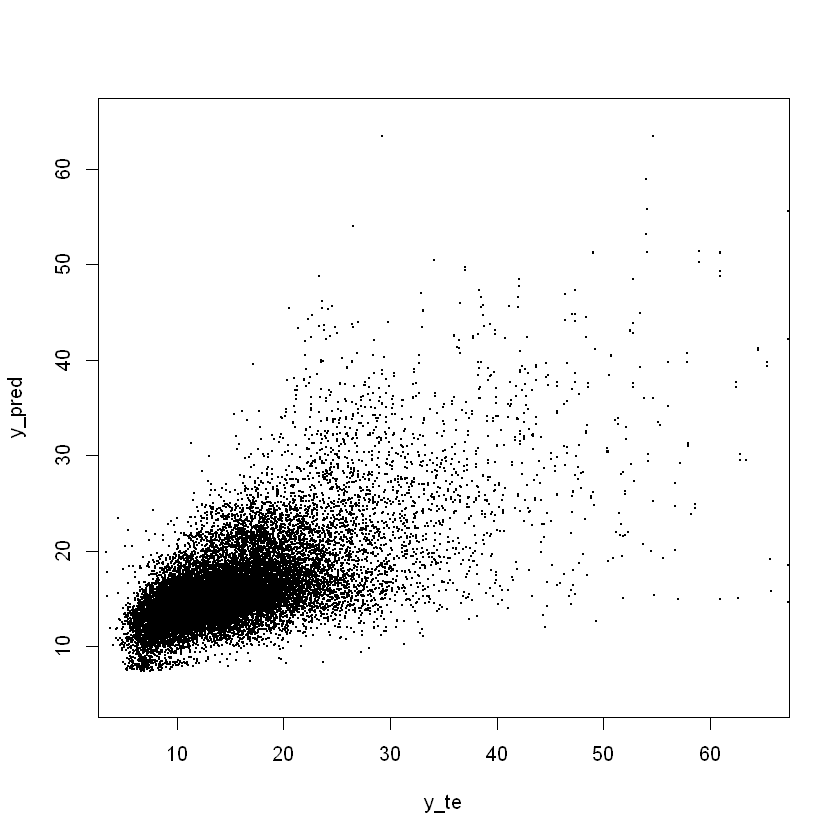

In [35]:
y_pred = predict(model1, x_te)
cat("rmse = ", rmse(y_te, y_pred), "\n")
cat("cor pearson = ", cor(y_te, y_pred, method = "pearson"), "\n")
plot(y_te, y_pred, xlim=c(5,65), ylim=c(5,65), pch=20, cex = 0.1)

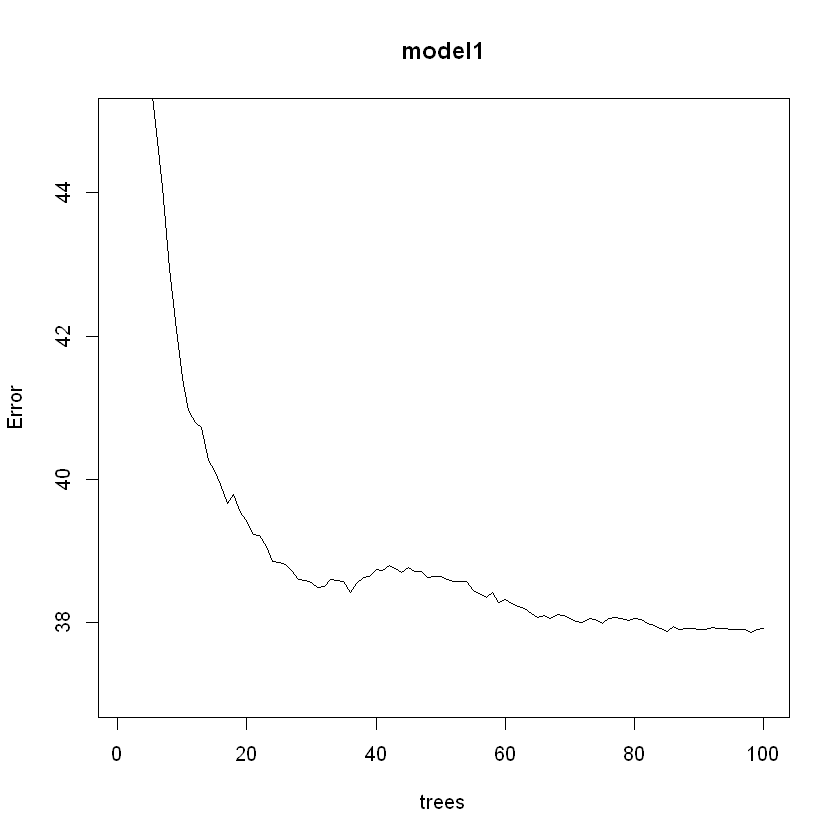

In [30]:
plot(model1, ylim=c(37,45))

### Optimizacion

In [ ]:
ntree = 100 # 150
mtry = 50 # 50
maxnodes = 46 # 46 o mas
nodesize = 50 # 50 # seq(300,700,200) # 100 creo k varia poco

resis = c()
for(v1 in ntree){
    for(v2 in mtry){
        for(v3 in maxnodes){
            for(v4 in nodesize){
                cat(v1,v2,v3,v4,"\n")
                flush.console()
                
                model2 = randomForest(x = x_tr, y = y_tr,
                      ntree = v1,
                      mtry = v2,
                      
#                       maxnodes = v3,
#                       nodesize = v4,
                      
                      replace = FALSE,
                      sampsize = ceiling(nrow(x_tr)*0.1),
                                      
#                       importance = TRUE,
#                       corr.bias = TRUE,
                    )
                resis = cbind(resis, model2$mse)
            }
        }
    }
}

In [ ]:
plot(resis[,1], ylim=c(40,50) )
lines(resis[,2], col="red")
lines(resis[,3], col = "orange")
lines(resis[,4], col = "yellow")
lines(resis[,5], col = "green")
# lines(resis[,6], col = "lightblue")
# lines(resis[,7], col = "blue")
# lines(resis[,8], col = "purple")
# lines(resis[,9], col = "pink")
# lines(resis[,10], col = "lightblue")
# lines(resis[,11], col = "blue")

In [ ]:
# str(model2)
# model2$mse[5]
# sqrt(model2$mse[20])

In [ ]:
plot(model2)

In [ ]:
y_pred = predict(model2, x_tr)
cat("rmse = ", rmse(y_tr, y_pred), "\n")
cat("cor pearson = ", cor(y_tr, y_pred, method = "pearson"), "\n")

mean(y_tr)
mean(y_pred)
plot(y_tr, y_pred, xlim=c(5,65), ylim=c(5,65), pch=20, cex = 0.1)

In [ ]:
y_pred = predict(model2, x_te)
cat("rmse = ", rmse(y_te, y_pred), "\n")
cat("cor pearson = ", cor(y_te, y_pred, method = "pearson"), "\n")

mean(y_te)
mean(y_pred)
plot(y_te, y_pred, xlim=c(5,65), ylim=c(5,65), pch=20, cex = 0.1)

In [ ]:
min(y_pred)

# Single tree

In [36]:
trc = tree.control(length(y_tr), minsize = 2, mindev = 0.01)
model3 = tree(ActualDuration~. , citas, subset=i, control = trc)

In [42]:
model3

node), split, n, deviance, yval
      * denotes terminal node

 1) root 53817 5149000.0  15.76  
   2) ActivityCode: Braquiterapia,Cambio de tÃ©cnica,Cambio horario,Compensacion,Daily Treatment,Dosis Ãºnica,Fin Tratamiento,MU Calculation,Necesita celador,New Start,Tratamiento SBRT-Exactrac,Tratamiento semanal,Urgencias 53598 4099000.0  15.55  
     4) NumPlans < 1.5 51120 2840000.0  14.86  
       8) ScheduledActivityCode: Completed 51099 2373000.0  14.81  
        16) ActivityCode: Braquiterapia,Cambio horario,Compensacion,Daily Treatment,Fin Tratamiento,Necesita celador 46770 1802000.0  14.17  
          32) NumFields < 8.5 35856 1139000.0  13.39  
            64) EnergyModeSer: 72,111,112,113,114,121,122,123,127,131,132 20680  728500.0  12.35 *
            65) EnergyModeSer: 71 15176  357200.0  14.81 *
          33) NumFields > 8.5 10914  568200.0  16.75 *
        17) ActivityCode: Cambio de tÃ©cnica,Dosis Ãºnica,MU Calculation,New Start,Tratamiento SBRT-Exactrac,Tratamiento semanal

In [37]:
y_pred = predict(model3, x_tr)
cat("rmse = ", rmse(y_tr, y_pred), "\n")
cat("cor pearson = ", cor(y_tr, y_pred, method = "pearson"), "\n")

y_pred = predict(model3, x_te)
cat("rmse = ", rmse(y_te, y_pred), "\n")
cat("cor pearson = ", cor(y_te, y_pred, method = "pearson"), "\n")

rmse =  7.10462 
cor pearson =  0.6874764 
rmse =  7.55067 
cor pearson =  0.6799237 


In [38]:
# plot(y_te, y_pred, xlim=c(5,65), ylim=c(5,65), pch=20)

In [41]:
levels(citas$ActivityCode)

[1] "Braquiterapia"             "Cambio de tÃ©cnica"       
 [3] "Cambio horario"            "Compensacion"             
 [5] "Daily Treatment"           "Dosis Ãºnica"             
 [7] "Fin Tratamiento"           "ICT"                      
 [9] "Inicio SBRT Exactrac"      "MU Calculation"           
[11] "Necesita celador"          "New Start"                
[13] "RadiocirugÃ­a"             "Transplante"              
[15] "Tratamiento de Urgencia"   "Tratamiento Electrones"   
[17] "Tratamiento Oncothermia"   "Tratamiento SBRT-Exactrac"
[19] "Tratamiento semanal"       "Urgencias"

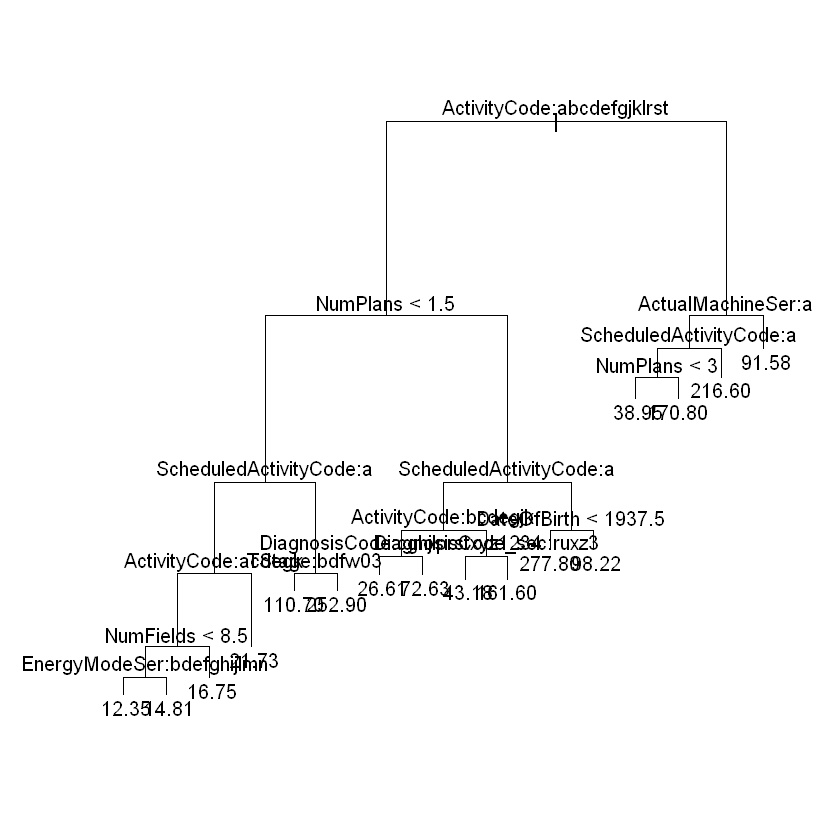

In [39]:
plot(model3)
text(model3)